# ASSIGNMENT 1: ECG Signal Processing and Analysis

Dataset: BIDMC Congestive Heart Failure Database
Link: https://physionet.org/content/chfdb/1.0.0/

### 1. ECG Signal Acquisition

In [2]:
#pip install wfdb

In [3]:
import wfdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks

In [4]:
#Loading of ECG signal of record chf01
record = wfdb.rdrecord('C:/Users/sofyc/OneDrive/Desktop/UPEC/Data capture and processing/assignment 1/bidmc-congestive-heart-failure-database-1.0.0/files/chf01')

#Extracting data from signal
signal = record.p_signal

#Conversion into DataFrame
df = pd.DataFrame(signal, columns=record.sig_name)

#Saving in CSV
df.to_csv('output.csv', index=False)
#path for output.csv: "C:\Users\sofyc\OneDrive\Desktop\UPEC\Data capture and processing\assignment 1\output.csv"

In [151]:
#Check NA
df.isna().sum()

ECG1    0
ECG2    0
dtype: int64

In [154]:
#Check 0
print((df['ECG1'].values == 0).sum(), (df['ECG2'].values == 0).sum())

19934 53085


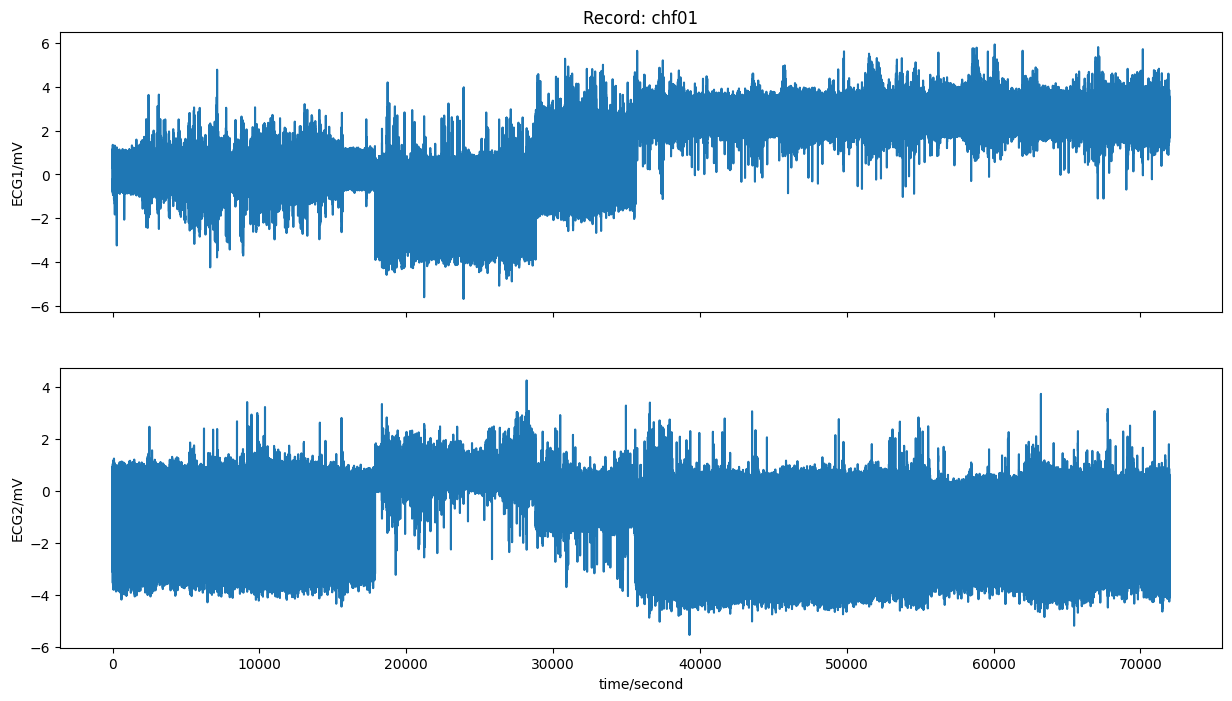

In [5]:
wfdb.plot_wfdb(record=record, time_units='seconds',figsize=(15,8))

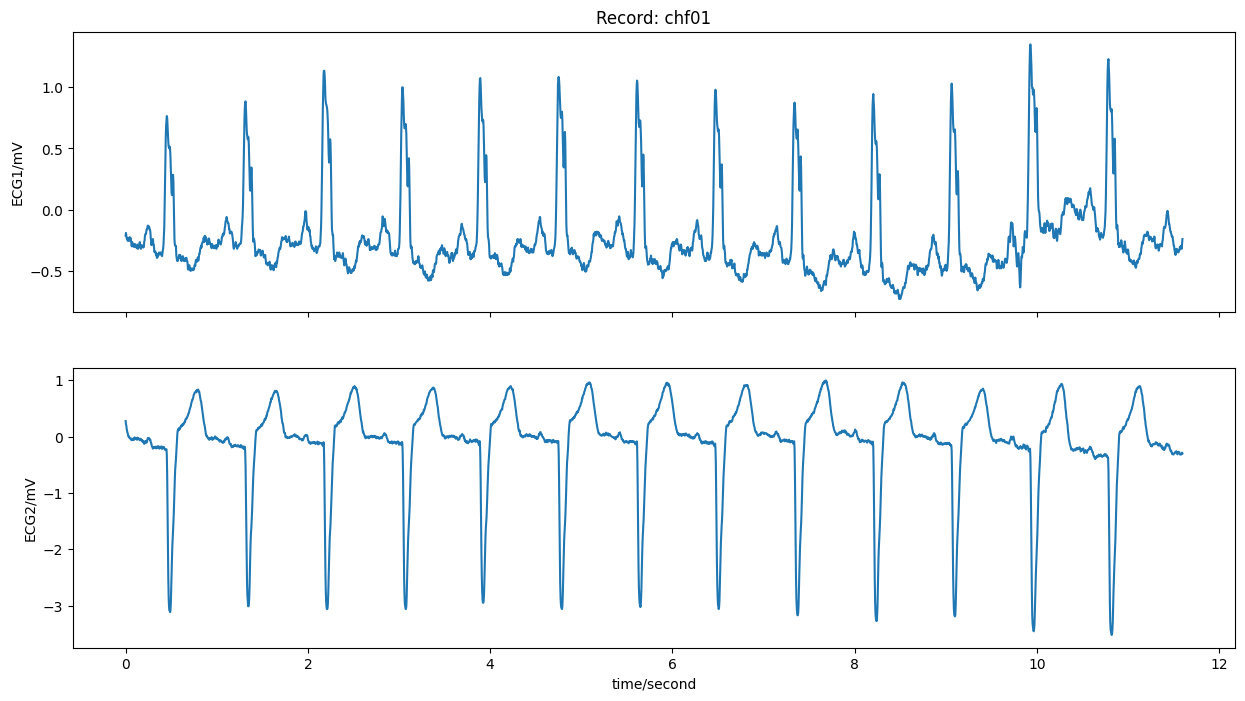

In [6]:
#To look better at the signal we can just visualize a part
record2 = wfdb.rdrecord('C:/Users/sofyc/OneDrive/Desktop/UPEC/Data capture and processing/assignment 1/bidmc-congestive-heart-failure-database-1.0.0/files/chf01',
                        sampfrom=100, sampto=3000)
wfdb.plot_wfdb(record=record2, time_units='seconds',figsize=(15,8))

### 2. Basic Signal Characteristics

In [7]:
df

,ECG1,ECG2
0,0.635,-0.640
1,0.680,-1.280
2,0.630,-1.920
3,0.570,-2.535
4,0.535,-2.800
...,...,...
17994486,2.255,-0.520
17994487,2.245,-0.530
17994488,2.265,-0.520
17994489,2.245,-0.500


- Average signal value (mean of the signal)

In [8]:
mean_ECG1 = df['ECG1'].mean()
mean_ECG2 = df['ECG2'].mean()
print(f"mean ECG1: {mean_ECG1:0.3f} \nmean ECG2: {mean_ECG2:0.3f}")

mean ECG1: 1.183 
mean ECG2: -0.346


- Energy of the signal (sum of the squared values)

In [9]:
energy_ECG1 = np.sum(df['ECG1']**2)
energy_ECG2 = np.sum(df['ECG2']**2)
print(f"energy ECG1: {energy_ECG1:0.3f} \nenergy ECG2: {energy_ECG2:0.3f}")

energy ECG1: 58371197.127 
energy ECG2: 13065603.215


- Variance

In [10]:
var_ECG1 = df['ECG1'].var()
var_ECG2 = df['ECG2'].var()
print(f"var ECG1: {var_ECG1:0.3f} \nvar ECG2: {var_ECG2:0.3f}")

var ECG1: 1.845 
var ECG2: 0.606


- Signal-to-noise ratio (SNR)

In [11]:
SNR_ECG1 = 10 * np.log10(energy_ECG1/var_ECG1)
SNR_ECG2 = 10 * np.log10(energy_ECG2/var_ECG2)
print(f"SNR ECG1: {SNR_ECG1:0.3f} dB \nSNR ECG2: {SNR_ECG2:0.3f} dB")

SNR ECG1: 75.001 dB 
SNR ECG2: 73.334 dB


### 3. R-peak Detection

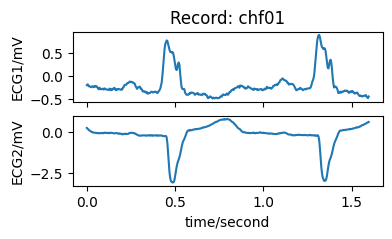

In [12]:
record_peak = wfdb.rdrecord('C:/Users/sofyc/OneDrive/Desktop/UPEC/Data capture and processing/assignment 1/bidmc-congestive-heart-failure-database-1.0.0/files/chf01',
                        sampfrom=100, sampto=500)
wfdb.plot_wfdb(record=record_peak, time_units='seconds',figsize=(4,2))

- Band-pass Filter (0.5-40 Hz): to reduce noise at frequencies outside the band and maintaining the same information of frequency's values at frequencies inside. 

In [114]:
#Function for Butterworth filter: a digital filter that doesn't introduce variation in the segnal of the band-pass (frequencies we want to maintain).
#Out of the band, the filter reduces gradually the width of frequencies. This "lower" answer of the filter doesn't introduce distortions in the filtering of the signal.
#'butter' function calculates the coefficients of Butterworth filter that will be used to filter the signal.

fs = 250 #sampling frequency of 250 Hz
low_cutoff = 0.5  #cutoff frequency of high-pass filter
high_cutoff = 35  #cutoff frequency of low-pass filter

def bandpass_butterworth(lowcut, highcut, fs, order=4):
    #higher order means a narrower transition between the maintained (i.e. passed) band, and the chnged band, but this can cause distortions
    #analog=False since it is a digital filter
    nyquist = 0.5 * fs #Nyquist Theorem: f_sampling >= 2*f_max --> f_sampling = fs
    low = lowcut / nyquist #normalized frequency
    high = highcut / nyquist #normalized frequency
    b, a = butter(order, [low, high], btype='band') #coefficients of Butterworth filter
    return b, a

#Function of band-pass filter: here we use filtfilt to apply the filter to the signal. 
#This function does the filtering for two times (one forward and one backward), to avoid distortions.
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = bandpass_butterworth(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

#Application to data
filtered_ecg1 = bandpass_filter(df['ECG1'].values, low_cutoff, high_cutoff, fs)
filtered_ecg2 = bandpass_filter(df['ECG2'].values, low_cutoff, high_cutoff, fs)


- Thresholding method

In [128]:
#Threshold: the 60% of the maximum
t_ecg1 = 0.6 * max(filtered_ecg1)
t_ecg2 = 0.6 * max(filtered_ecg2)

#Extracting the peaks from the second derivatives
peaks_ecg1, _ = find_peaks(filtered_ecg1, height=t_ecg1, distance=150)
peaks_ecg2, _ = find_peaks(filtered_ecg2, height=t_ecg2, distance=150)

In [129]:
peaks_ecg2

array([  626291,  1555973,  1710978,  2117913,  2290752,  2316505,
        2364972,  2462218,  2472465,  2571696,  2594650,  8664198,
        8685741,  8685971,  8740048,  9112704,  9120014,  9178007,
        9188471,  9189472,  9214909,  9278749,  9348058,  9360088,
        9416489,  9441779,  9462842,  9485200,  9517631,  9604203,
        9658834,  9770310,  9823016,  9835536,  9989911, 10238932,
       10381660, 10422135, 11141040, 12305778, 12365219, 12444000,
       12926523, 13227400, 13235995, 13279415, 13294995, 13327294,
       13400765, 13476692, 13675089, 13743317, 13792560, 13886549,
       15598755, 15806079, 16023226, 16986252, 17206637, 17741203,
       17985573], dtype=int64)

- Plot the ECG signal and mark the detected R-peaks.

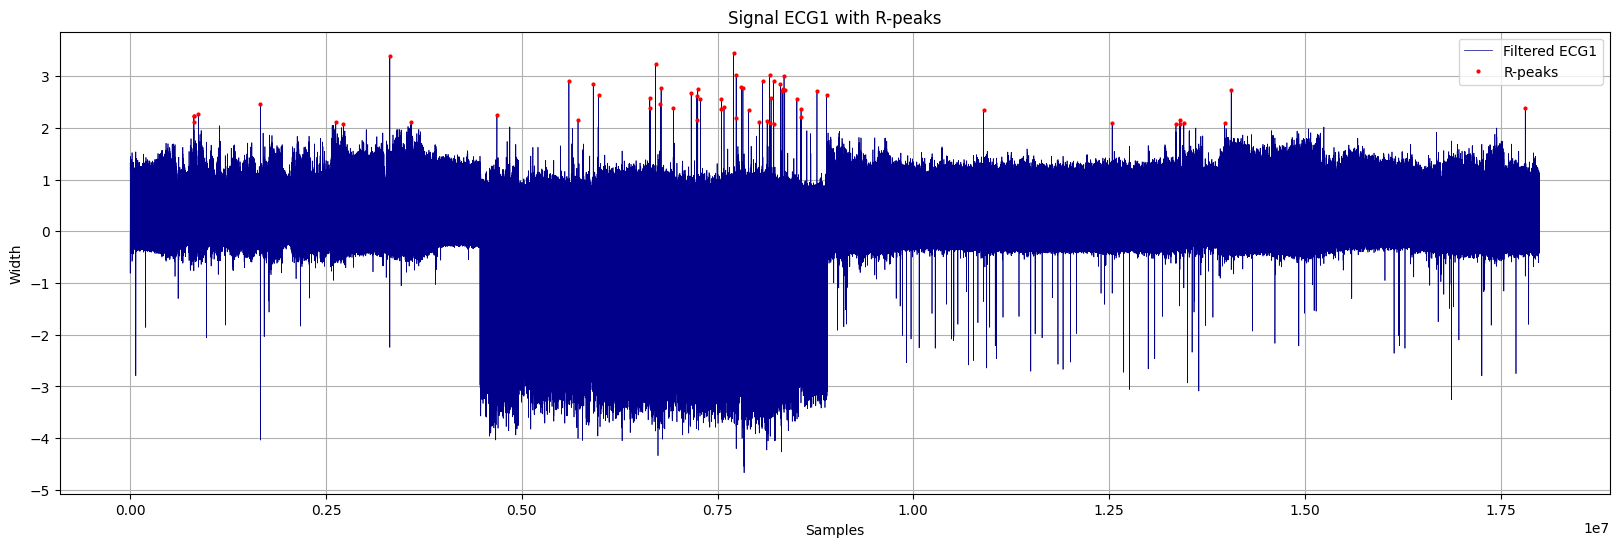

In [130]:
#ECG1 plot R-peaks
plt.figure(figsize=(20, 6))
plt.plot(filtered_ecg1, label="Filtered ECG1", linewidth=0.5, color='darkblue')
#R-peaks in red
plt.plot(peaks_ecg1, filtered_ecg1[peaks_ecg1], "ro", label="R-peaks", markersize=2)

plt.title("Signal ECG1 with R-peaks")
plt.xlabel("Samples")
plt.ylabel("Width")
plt.legend()
plt.grid(True)
plt.show()

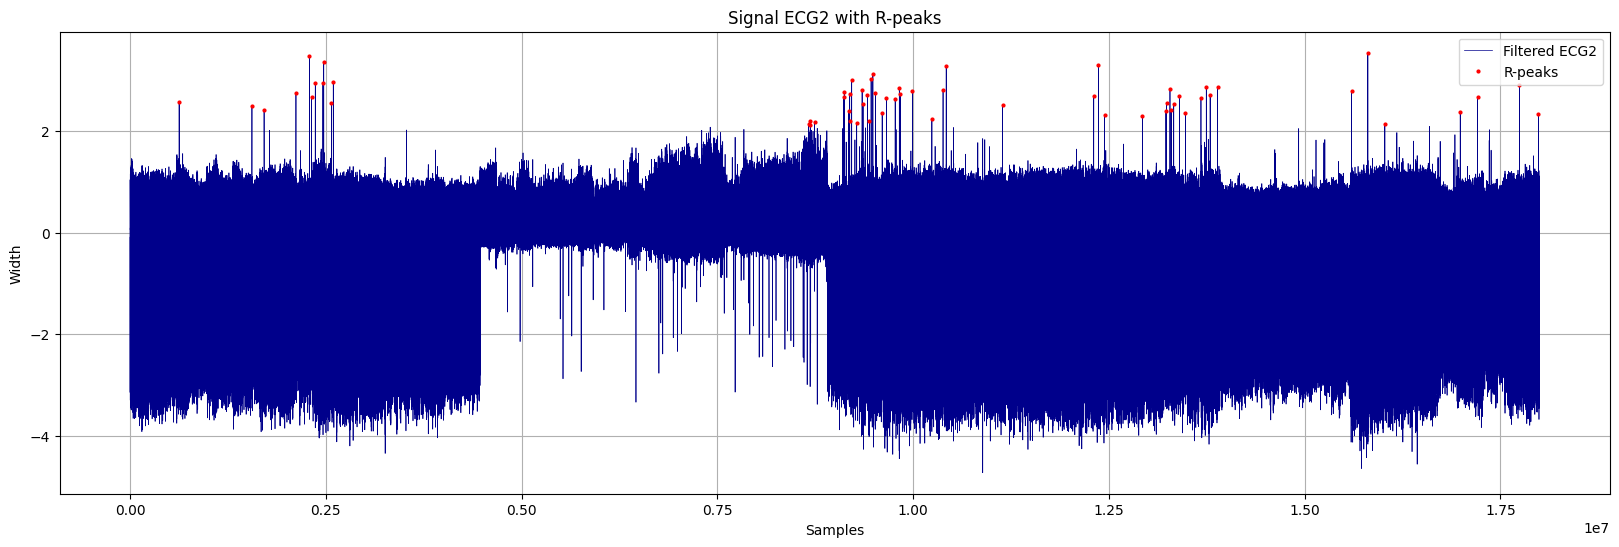

In [131]:
#ECG2 plot R-peaks
plt.figure(figsize=(20, 6))
plt.plot(filtered_ecg2, label="Filtered ECG2", linewidth=0.5, color='darkblue')
#R-peaks in red
plt.plot(peaks_ecg2, filtered_ecg2[peaks_ecg2], "ro", label="R-peaks", markersize=2)

plt.title("Signal ECG2 with R-peaks")
plt.xlabel("Samples")
plt.ylabel("Width")
plt.legend()
plt.grid(True)
plt.show()

### 4. Cardiovascular Parameter Calculation

- RR intervals: Measure the time between consecutive R-peaks (i.e. distance between the picks R in samples).

In [132]:
rr_intervals_ecg1 = np.diff(peaks_ecg1)
rr_intervals_ecg2 = np.diff(peaks_ecg2)
print("RR intervals ECG1: ", rr_intervals_ecg1, "\n", "RR intervals ECG2: ", rr_intervals_ecg2)

RR intervals ECG1:  [    218     220   58827  789909  962856   97457  592777  272576 1095477
  919199  116383  195009   67216  654135    7569   65831   63226    8105
  156398  228261   71982    1110    9549   35483  266750     661   33026
  121413   33923     299   66568   19395   71896  137272   41068   59359
   31732    7589   10486   32468    1839   84361   21586    7452   17869
    8453  155510   51516    1756  203333  123357 2003688 1643003  814502
   50229     212   49694  520250   85261 3755269] 
 RR intervals ECG2:  [ 929682  155005  406935  172839   25753   48467   97246   10247   99231
   22954 6069548   21543     230   54077  372656    7310   57993   10464
    1001   25437   63840   69309   12030   56401   25290   21063   22358
   32431   86572   54631  111476   52706   12520  154375  249021  142728
   40475  718905 1164738   59441   78781  482523  300877    8595   43420
   15580   32299   73471   75927  198397   68228   49243   93989 1712206
  207324  217147  963026  220385

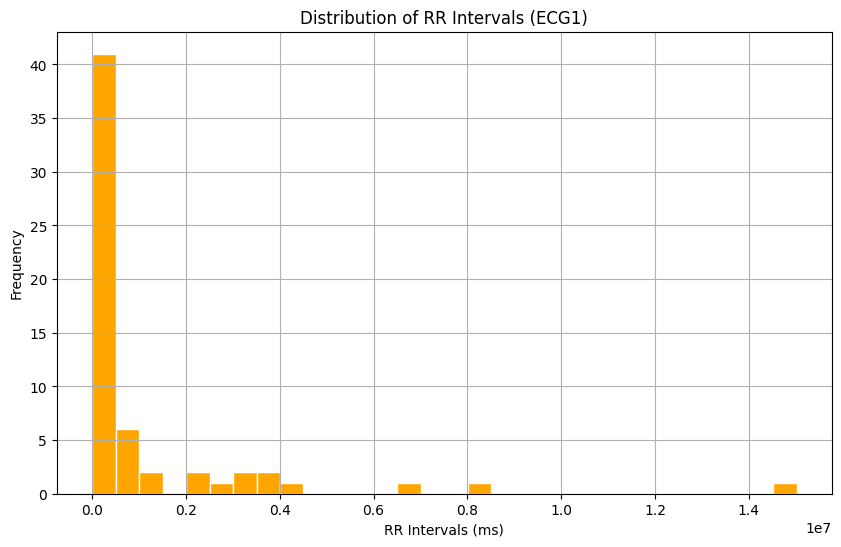

In [133]:
# RR Intervals plot for ECG1
rr_intervals_ms_ecg1 = rr_intervals_ecg1 / fs * 1000  # Convert RR intervals to ms

plt.figure(figsize=(10, 6))
plt.hist(rr_intervals_ms_ecg1, bins=30, color='orange', edgecolor='white')
plt.title('Distribution of RR Intervals (ECG1)')
plt.xlabel('RR Intervals (ms)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

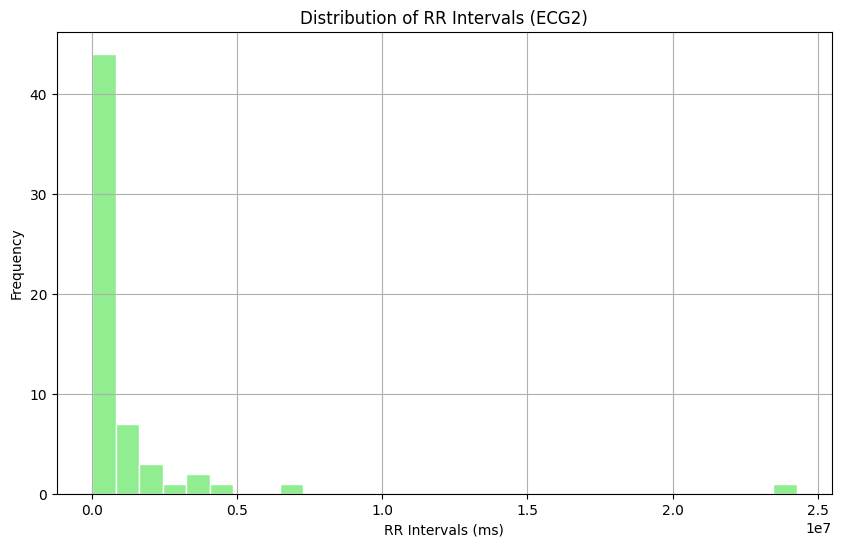

In [134]:
# RR Intervals plot for ECG2
rr_intervals_ms_ecg2 = rr_intervals_ecg2 / fs * 1000  # Convert RR intervals to ms

plt.figure(figsize=(10, 6))
plt.hist(rr_intervals_ms_ecg2, bins=30, color='lightgreen', edgecolor='white')
plt.title('Distribution of RR Intervals (ECG2)')
plt.xlabel('RR Intervals (ms)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

- Heart rate (beats per minute): Calculate the time interval between consecutive R-peaks and compute the heart rate.

In [135]:
#Assuming a sampling frequency of 250 Hz
fs = 250
heart_rate_ecg1 = 60 / (rr_intervals_ecg1 / fs)
heart_rate_ecg2 = 60 / (rr_intervals_ecg2 / fs)
print("Heart Rate ECG1: ", heart_rate_ecg1, "\n", "Heart Rate ECG2: ", heart_rate_ecg2)

Heart Rate ECG1:  [6.88073394e+01 6.81818182e+01 2.54984956e-01 1.89895292e-02
 1.55786535e-02 1.53914034e-01 2.53046255e-02 5.50305236e-02
 1.36926654e-02 1.63185556e-02 1.28884803e-01 7.69195268e-02
 2.23161152e-01 2.29310463e-02 1.98176774e+00 2.27856177e-01
 2.37244172e-01 1.85070944e+00 9.59091548e-02 6.57142482e-02
 2.08385430e-01 1.35135135e+01 1.57084511e+00 4.22737649e-01
 5.62324274e-02 2.26928896e+01 4.54187610e-01 1.23545255e-01
 4.42177873e-01 5.01672241e+01 2.25333494e-01 7.73395205e-01
 2.08634695e-01 1.09272102e-01 3.65247882e-01 2.52699675e-01
 4.72708937e-01 1.97654500e+00 1.43047873e+00 4.61993347e-01
 8.15660685e+00 1.77807281e-01 6.94894839e-01 2.01288245e+00
 8.39442610e-01 1.77451792e+00 9.64568195e-02 2.91171675e-01
 8.54214123e+00 7.37706127e-02 1.21598288e-01 7.48619546e-03
 9.12962423e-03 1.84161610e-02 2.98632264e-01 7.07547170e+01
 3.01847306e-01 2.88322922e-02 1.75930378e-01 3.99438762e-03] 
 Heart Rate ECG2:  [1.61345492e-02 9.67710719e-02 3.68609237e-02 

In [136]:
print(np.mean(heart_rate_ecg1), np.mean(heart_rate_ecg2))

5.546039872978505 1.6960809364092526


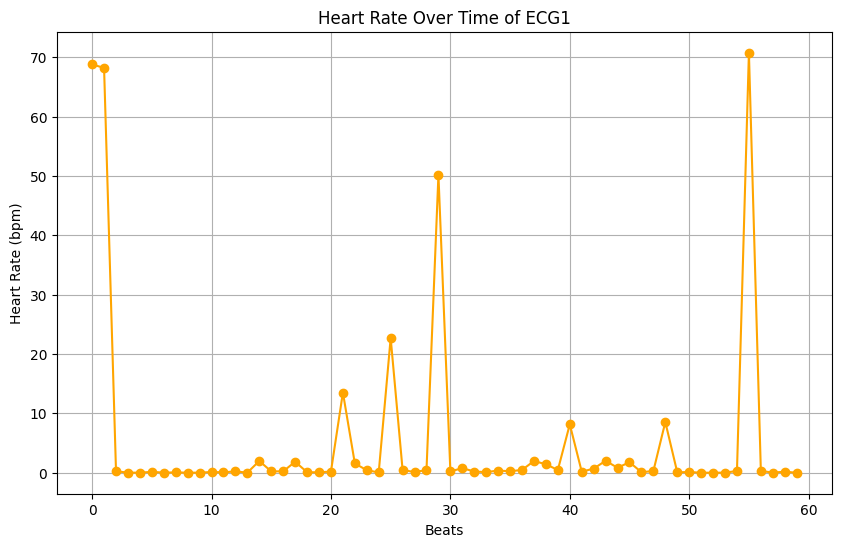

In [137]:
#Heart rate ECG1
plt.figure(figsize=(10, 6))
plt.plot(heart_rate_ecg1, marker='o', linestyle='-', color='orange')
plt.title('Heart Rate Over Time of ECG1')
plt.xlabel('Beats')
plt.ylabel('Heart Rate (bpm)')
plt.grid(True)
plt.show()

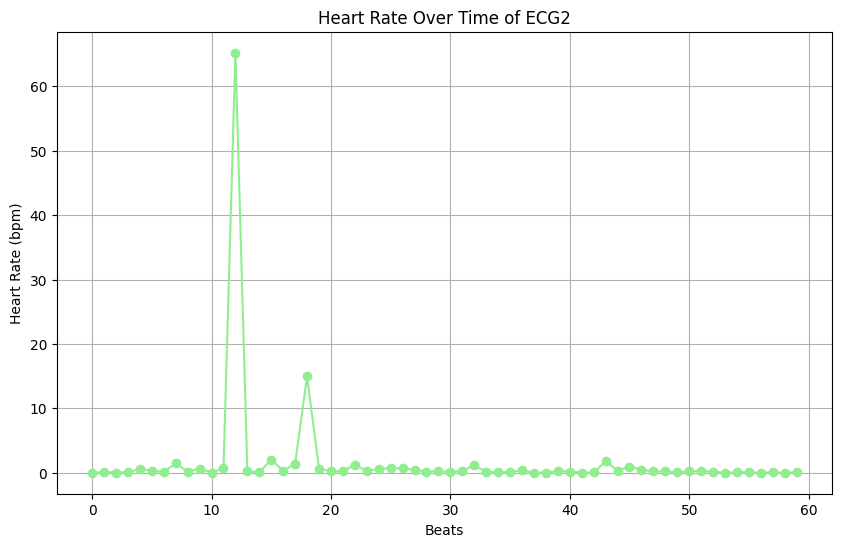

In [138]:
#Heart rate ECG2
plt.figure(figsize=(10, 6))
plt.plot(heart_rate_ecg2, marker='o', linestyle='-', color='lightgreen')
plt.title('Heart Rate Over Time of ECG2')
plt.xlabel('Beats')
plt.ylabel('Heart Rate (bpm)')
plt.grid(True)
plt.show()

- Heart rate variability (HRV): Compute the standard deviation of the RR intervals (SDNN) or other HRV metrics if necessary.

In [139]:
#Calculating the variability of heart frequency (HRV) as standard deviation of the intervals RR
hrv_ecg1 = np.std(rr_intervals_ecg1)
hrv_ecg2 = np.std(rr_intervals_ecg2)
print("Heart rate variability ECG1: ", hrv_ecg1, "\n", "Heart rate variability ECG2: ", hrv_ecg2)

Heart rate variability ECG1:  602361.921511182 
 Heart rate variability ECG2:  814843.456518387
